# Lab Outline

## Online

#### This document
<font color="#f22" >
You can find the most up-to-date version of this document online [here](https://github.com/mjbright/jupyter_notebooks/blob/master/2016-Feb_Docker_Build_Lab/2016-Feb_Docker_Build_Lab.md) or as
<br/>
- a [PDF file](https://raw.githubusercontent.com/mjbright/jupyter_notebooks/master/2016-Feb_Docker_Build_Lab/2016-Feb_Docker_Build_Lab.pdf) (http://bit.ly/1QF0XaH)  or as
<br/>
- a [Jupyter](http://www.jupyter.org) notebook at [2016-Feb_Docker_Build_Lab](https://github.com/mjbright/jupyter_notebooks/blob/master/2016-Feb_Docker_Build_Lab/).
</font>

This notebook is runnable in a Jupyter installation with the bash_kernel installed.

Although that is not the subject of this lab, if you want to create your own environment in which to run this lab with Docker components already installed (and even Jupyter/bash_kernel), refer to the README.md [here](https://github.com/mjbright/jupyter_notebooks/blob/master/2016-Feb_Docker_Build_Lab/)

<br/><br/><br/>
<center><font size=-1 color="#77f">
    <i class="fa-linkedin fa-2x fa"> [mjbright](https://www.linkedin.com/in/mjbright)</i>,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    <i class="fa-github fa-2x fa"> [mjbright](https://github.com/mjbright)</i>,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    <i class="fa-twitter fa-2x fa">[@mjbright](http://twitter.com/mjbright)</i>,
</font></center>


<a name="TOP"></a>
## Lab-Description
[TOP](#TOP)


We first need to recuperate the source code examples:

<font color="#f22">
### Lab Start
</font>
Start this lab by first performing the below step:

In [1]:
## Lab Start:

rm -rf ~/src

cd
git clone https://github.com/mjbright/docker-examples src

./src/START_LAB.sh

Cloning into 'src'...
remote: Counting objects: 156, done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 156 (delta 64), reused 120 (delta 31), pack-reused 0
Receiving objects: 100% (156/156), 15.60 KiB | 0 bytes/s, done.
Resolving deltas: 100% (64/64), done.
Checking connectivity... done.


Then procede with the following sections:

- [1. Introduction](#intro)
- [2. Basic Docker Builds](#builds)
- [3. Creating Small Images](#small-images)
  - [Creating a small binary with C](#small-c)
  - [Creating a small binary with Go](#small-go)
  - [Creating a toolset Docker image containing several executables](#small-push)
  
- [4. Pushing our image to Docker Hub](#small-multi)
  
- [5. Dockerfile best practices](#build-best-practices)

- [6. Using the official 'Language Stack' images](#lang-stacks)
  - [Using a Language Stack (Node.js)](#medium-node)
  - [Using a Language Stack (Python)](#medium-python)
  
- [7. Using Compose](#compose)
  - [Building complex systems with Compose](#Compose)
  - [Rails example with Compose](#Rails-Example-with-Compose)
  
- [8. Building Docker](#building-docker)
  - [Building Docker with Docker](#Building-Docker-with-Docker)

[References](#References)

<hr/>
  
### Overall description of the lab steps

**NOTE: All lab steps can be considered optional, attendees may perform them in order, or jump to the section of interest to them (to get to the more complicated steps)**


<a name="1.intro" />
# Introduction
## A refresh on Docker concepts

You may want to skip this section if you have already run the introductory lab.

Look at what docker version you are running.
Note that the 'docker version' command reports the local client version as well as the server (docker engine) version.

In [2]:
docker version

Client:
 Version:      1.10.0
 API version:  1.22
 Go version:   go1.5.3
 Git commit:   590d5108
 Built:        Thu Feb  4 19:55:25 2016
 OS/Arch:      linux/amd64

Server:
 Version:      1.10.0
 API version:  1.22
 Go version:   go1.5.3
 Git commit:   590d5108
 Built:        Thu Feb  4 19:55:25 2016
 OS/Arch:      linux/amd64


### Images are image layers

Remember that when we talk of a container image it is really a collection of image layers.

The docker info command provides information about the docker engine, see below.

In [4]:
docker info

Containers: 1
 Running: 0
 Paused: 0
 Stopped: 1
Images: 7
Server Version: 1.10.0
Storage Driver: aufs
 Root Dir: /var/lib/docker/aufs
 Backing Filesystem: extfs
 Dirs: 30
 Dirperm1 Supported: false
Execution Driver: native-0.2
Logging Driver: json-file
Plugins: 
 Volume: local
 Network: null host bridge
Kernel Version: 3.13.0-77-generic
Operating System: Ubuntu 14.04.3 LTS
OSType: linux
Architecture: x86_64
CPUs: 1
Total Memory: 1.955 GiB
Name: vagrant-ubuntu-trusty-64
ID: 3BDW:ZNNN:SJXZ:MAT3:WBKG:4RQT:PEZJ:7PDN:VG72:XGAL:CU6U:XWX4


But if we look at the number of containers and images, the number of images it is not the same as provided above.
Why do you think that is?

First let's list the number of running and number of stopped containers

**NOTE: the value on your system will be different**

In [5]:
# Show the running containers:
docker ps

# Count the number of running containers:
echo
echo "Total number of running containers:"
docker ps | tail -n +2 | wc -l

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES

Total number of running containers:
0


In [6]:
# Show all the containers (running or stopped):
docker ps -a

# Count all the containers (running or stopped):
echo
echo "Total number of containers (running or stopped):"
docker ps -a | tail -n +2 | wc -l # Number of stopped and running containers ('tail -n +2' excludes the header line)

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS                       PORTS               NAMES
b19891aa2715        lab/c_prog          "/helloWorld"       24 seconds ago      Exited (14) 23 seconds ago                       nauseous_mestorf

Total number of containers (running or stopped):
1


We can see that the number of containers reported by docker info correctly reports the number of total containers, running or not

But listing images gives a different value from the 'docker info' value

In [7]:
# Show the images:
docker images

# Count the images:
echo
echo "Total number of images:"
docker images | tail -n +2 | wc -l

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/c_prog          latest              659400ddd8d4        31 seconds ago      877.2 kB
swarm               latest              17cf22083736        3 days ago          18.11 MB
node                latest              baa18fdeb577        12 days ago         643.1 MB
swarm               1.1.0-rc2           81883ac55ffe        2 weeks ago         18.06 MB
alpine              latest              14f89d0e6257        2 weeks ago         4.794 MB

Total number of images:
5


That is because there are many intermediate image layers which are not normally listed.
But we can list those layers using the '-a' option and now we see a number close to the value from 'docker info'.

(We will see later how the 'docker history' command allows us to see how the layers were created).

In [8]:
# Show all the image layers:
docker images -a

# Count all the image layers:
echo
echo "Total number of image layers:"

docker images -a | tail -n +2 | wc -l  # The number of image layers+1 (inc. header line)

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
<none>              <none>              8e9605157ccf        42 seconds ago      0 B
<none>              <none>              bde06bb6dcf5        42 seconds ago      877.2 kB
lab/c_prog          latest              659400ddd8d4        42 seconds ago      877.2 kB
swarm               latest              17cf22083736        3 days ago          18.11 MB
node                latest              baa18fdeb577        12 days ago         643.1 MB
swarm               1.1.0-rc2           81883ac55ffe        2 weeks ago         18.06 MB
alpine              latest              14f89d0e6257        2 weeks ago         4.794 MB

Total number of image layers:
7


Images can include 1 static binary file or more and can even include a whole distribution.
Launching a container launches a single process within that container - which may in turn span other child processes.

Let us look at an extremely small image to have an idea just how small an executable image can be.
Docker provide an official 'hello-world' image which simply echoes some output to the console.

Let's run that image to see and then investigate the image.
First let's search for the image; we see that the first image is 'hello-world' which is an official build

In [9]:
docker search hello-world

NAME                                     DESCRIPTION                                     STARS     OFFICIAL   AUTOMATED
hello-world                              Hello World! (an example of minimal Docker...   48        [OK]       
tutum/hello-world                        Image to test docker deployments. Has Apac...   19                   [OK]
marcells/aspnet-hello-world              ASP.NET vNext - Hello World                     2                    [OK]
bonomat/nodejs-hello-world               a simple nodejs hello world container           1                    [OK]
carinamarina/hello-world-app             This is a sample Python web application, r...   1                    [OK]
vegasbrianc/docker-hello-world                                                           1                    [OK]
carinamarina/hello-world-web             A Python web app, running on port 5000, wh...   1                    [OK]
wowgroup/hello-world                     Minimal web app for testing purposes  

Let's now run that image

In [10]:
docker run hello-world

# Note how we see the pulling of the image if not already available locally:

Unable to find image 'hello-world:latest' locally
latest: Pulling from library/hello-world


Digest: sha256:8be990ef2aeb16dbcb9271ddfe2610fa6658d13f6dfb8bc72074cc1ca36966a7
Status: Downloaded newer image for hello-world:latest

Hello from Docker.
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker Hub account:
 https://hub.docker.com

For more examples and ideas, visit:
 https://

If it took a while to run, this was due to the time needed to download the image before running it - see above.

Try the command a second time to see how it runs instantaneously as there is no need to download the image which already exists locally on the 'docker engine'.

In [11]:
docker run hello-world

# The second time there is no need to repull the image:


Hello from Docker.
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker Hub account:
 https://hub.docker.com

For more examples and ideas, visit:
 https://docs.docker.com/userguide/



Let us inspect the image.  We see that the file is only 960 bytes large, it must be machine code to print out the text.  So we see that an image can be really very small

In [12]:
docker images hello-world

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
hello-world         latest              690ed74de00f        3 months ago        960 B


We can also inspect the image with the history command to see how it was constructed.

Note that history shows the image layers in reverse order, latest first.

From the below command we can see that the image was created from only 2 image layers.

The image was built simply by copying in a binary executable and then specifying the default command to invoke when the image is run.

In [13]:
docker history hello-world

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
690ed74de00f        3 months ago        /bin/sh -c #(nop) CMD ["/hello"]                0 B                 
<missing>           3 months ago        /bin/sh -c #(nop) COPY file:1ad52e3eaf4327c8f   960 B               


In [14]:
echo
echo "Total size (in bytes) of text in 'hello-world' image:"
docker run hello-world | wc -c


Total size (in bytes) of text in 'hello-world' image:
801


So we see that 801 bytes of that executable is the actual text printed !
So the real program size is roughly 160 bytes (of assembler no doubt)

<a name="builds" />
## Basic Docker Builds
[TOP](#TOP)

#### Dockerfile

Images are built from Dockerfiles which contain a series of commands used to build up a docker image.
Note that each command in the Dockerfile results in a new image layer being created, no matter how trivial the command - even ENV "commands" create a new image layer.

In the following lab we will see how images can be built systematically from a Dockerfile using the 'docker build' command.

#### DockerHub

When we pull an image we pull it from a Docker Registry.  The [DockerHub](https://hub.docker.com/) is a free to use Docker registry allowing to store your own image files (which are publicly available unless you pay for your account) and to pull other image files of other users or officially provided images.

You can create images either by
- building them from a Dockerfile (thus in a **repeatable** manner)
- building them manually by modifying a running container and *'commit'*ing it's state

The DockerHub contains images which may be
- **Automated builds** (built from a git repository)
  - Such builds are usually built from an open-source git repo and so are called **Trusted builds** because the source code is available.
    *Note:* The github repo may contain binary files though
- **Official builds** are builds which are builds provided by partners or by Docker themselves

Other images may exist in the hub but their origin is unknown and so represent a security risk.

It is possible to search the DockerHub, or another Docker Registry, using the 'docker search' command with appropriate options.  Other companies offer their own Docker Registry which may be freely accessible e.g. RedHat, internal to a company e.g. HPE IT, or available as part of a paid for service e.g. IBM or Amazon Web Services ECS.


In [20]:
cd ~/src/basic

In the ~/test folder create a Dockerfile with the contents shown below (the o/p of the cat command).

For this you may use vi if you are familiar, otherwise the 'nano' text editor is recommended.

Use ctrl-W to write out the file and ctrl-X to quit the editor.

In [25]:
cat Dockerfile

#
# Dockerfile to demonstrate the simplest build
#

FROM python

MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

# NOTE: all RUN commands are executed at build time, look at the output of the "docker build"
#       below and you will see the output of the following line when we build the first time
#       (i.e. when caching is not used):

RUN echo DATE: This build is being done at $(date)
#RUN python ‐‐version

CMD bash



In [26]:
ls -altr Dockerfile

-rw-rw-r-- 1 vagrant vagrant 439 Feb  8 15:31 Dockerfile


We can now build a new image using this dockerfile using the below command where
    
- we specify the current directory as the context for the build (any ADD/COPY or Dockerfile files will be sourced from here) with
    the **'.'** option
- we specify the specific tag to use for the generated image as "*lab/basic*" with

    **-t lab/basic**

In [27]:
docker build -t lab/basic . 


Step 1 : FROM python
 ---> 93049cc049a6
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Running in 1e836ce0bd8b
 ---> 265f1e4a525d
Removing intermediate container 1e836ce0bd8b
Step 3 : RUN echo DATE: This build is being done at $(date)
 ---> Running in e195f1a8d6fc
DATE: This build is being done at Mon Feb 8 15:31:23 UTC 2016
 ---> 58100f46a8de
Removing intermediate container e195f1a8d6fc
Step 4 : CMD bash
 ---> Running in 6a24b4f9634c
 ---> c028a15ddd50
Removing intermediate container 6a24b4f9634c
Successfully built c028a15ddd50


Note that during the build, the RUN commands are actually run.

They are used to build up this new image.

In this case we echo the 'Python' version string during the build process.

You can see the available options to the build command by issuing
 'docker build --help'

In [28]:
docker build --help


Usage:	docker build [OPTIONS] PATH | URL | -

Build an image from a Dockerfile

  --build-arg=[]                  Set build-time variables
  --cpu-shares                    CPU shares (relative weight)
  --cgroup-parent                 Optional parent cgroup for the container
  --cpu-period                    Limit the CPU CFS (Completely Fair Scheduler) period
  --cpu-quota                     Limit the CPU CFS (Completely Fair Scheduler) quota
  --cpuset-cpus                   CPUs in which to allow execution (0-3, 0,1)
  --cpuset-mems                   MEMs in which to allow execution (0-3, 0,1)
  --disable-content-trust=true    Skip image verification
  -f, --file                      Name of the Dockerfile (Default is 'PATH/Dockerfile')
  --force-rm                      Always remove intermediate containers
  --help                          Print usage
  --isolation                     Container isolation level
  -m, --memory                    Memory limit
  --memory-swap       

We can see all the images available using the
 'docker images' command
 
but if there are many, how do we see just our newly-created image?

You can see the available options to the images command by issuing
 'docker images --help'

In [29]:
docker images --help


Usage:	docker images [OPTIONS] [REPOSITORY[:TAG]]

List images

  -a, --all          Show all images (default hides intermediate images)
  --digests          Show digests
  -f, --filter=[]    Filter output based on conditions provided
  --format           Pretty-print images using a Go template
  --help             Print usage
  --no-trunc         Don't truncate output
  -q, --quiet        Only show numeric IDs


So you can see your newly built 'lab/basic' with the following command:

In [30]:
docker images lab/basic

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/basic           latest              c028a15ddd50        18 seconds ago      689.1 MB


Note that if you rerun the build command, the build should run faster, you will notice how build steps recognize that this step has already been performed and so will use the image layer already available in the local cache.

Now let us see what happens if we modify our Dockerfile, by inserting a line, such as defining an environment variable.

We will use the same Dockerfile, but this time we will insert an "ENV" line


In [31]:
cd ~/src/basic/

Now edit the Dockerfile to have the contents as shown below (the o/p of the cat command).

In [32]:
cat Dockerfile

#
# Dockerfile to demonstrate the simplest build
#

FROM python

MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

# NOTE: all RUN commands are executed at build time, look at the output of the "docker build"
#       below and you will see the output of the following line when we build the first time
#       (i.e. when caching is not used):

RUN echo DATE: This build is being done at $(date)
#RUN python ‐‐version

ENV myVar=anythingReally

CMD bash



This time when we build the image we will see that the addition of a line between the "RUN" line and the "CMD" line forces rebuild of subsequent image layers.

**We see 'Using cache' for Step 2 and 3 only**

In [33]:
docker build -t lab/basic . 


Step 1 : FROM python
 ---> 93049cc049a6
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Using cache
 ---> 265f1e4a525d
Step 3 : RUN echo DATE: This build is being done at $(date)
 ---> Using cache
 ---> 58100f46a8de
Step 4 : ENV myVar anythingReally
 ---> Running in 86c9262af943
 ---> f493d0962635
Removing intermediate container 86c9262af943
Step 5 : CMD bash
 ---> Running in 42344c05af2a
 ---> 6566cf6ed29d
Removing intermediate container 42344c05af2a
Successfully built 6566cf6ed29d


Similarly we can force to not use the cache with the --no-cache option.

This could be useful if we suspect the caching is not working properly due to some external change.

In [34]:
docker build --no-cache -t lab/basic . 


Step 1 : FROM python
 ---> 93049cc049a6
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Running in 352ab6578552
 ---> c5efd78c5c14
Removing intermediate container 352ab6578552
Step 3 : RUN echo DATE: This build is being done at $(date)
 ---> Running in 2be6e59360a4
DATE: This build is being done at Mon Feb 8 15:35:15 UTC 2016
 ---> 77f9a84551cc
Removing intermediate container 2be6e59360a4
Step 4 : ENV myVar anythingReally
 ---> Running in f56c83b6c061
 ---> e7e8c2a26251
Removing intermediate container f56c83b6c061
Step 5 : CMD bash
 ---> Running in afdea0bc90b9
 ---> e3d7946e9d93
Removing intermediate container afdea0bc90b9
Successfully built e3d7946e9d93


In [35]:
docker images lab/basic

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/basic           latest              e3d7946e9d93        12 seconds ago      689.1 MB


<a name="small-images" />
## Creating small images
[TOP](#TOP)

<a name="small-c" />
## Creating a small C Docker image
[TOP](#TOP)

In this example we show how we can create a Docker image from a statically-linked binary.

<font size=+1 color="#77f">
<b>The goal of this step is to show that we do not need an Operating System image for a Docker container.</b>
</font>

All we need is a self-contained binary - i.e. statically linked binary.

Of course a dynamically linked binary could also be used, but in this case it's more complicated as you would have to manually add all it's dependent libraries.  Let's let gcc to do that work for us!

This section comprises 2 things
- A Dockerfile to build our image from a static binary
  Note that it starts with "FROM scratch".
  Scratch is a special 'empty' image
- helloFromDocker.c
  

So first let's build our static binary

In [36]:
cd ~/src/createTinyC/

# For RHEL/Fedora/Centos only:
# First we must install *glibc-static*
#yum install -y glibc-static

gcc -static helloWorld.c -o helloWorld

ls -alh helloWorld

-rwxrwxr-x 1 vagrant vagrant 857K Feb  8 15:35 helloWorld


So we see that this created a binary file of approximately 857kby.

Now let's build our Docker image containing this binary.

You will need to recreate the Dockerfile as follows:

In [37]:
cat Dockerfile


FROM scratch
MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

ADD ./helloWorld /helloWorld
CMD ["/helloWorld"]



In [38]:
docker build -t lab/c_prog .


Step 1 : FROM scratch
 ---> 
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Using cache
 ---> 8e9605157ccf
Step 3 : ADD ./helloWorld /helloWorld
 ---> Using cache
 ---> bde06bb6dcf5
Step 4 : CMD /helloWorld
 ---> Using cache
 ---> 659400ddd8d4
Successfully built 659400ddd8d4


If we now look at the generated Docker image (below) we see an image of about 877kby.

So whilst this is larger than the 1kby hello-world image (no doubt written in assembler) it is still a very small Docker image which is only 20kbytes larger than the original binary file.

In [39]:
docker images lab/c_prog

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/c_prog          latest              659400ddd8d4        17 hours ago        877.2 kB


And now let's run that image

In [40]:
docker run lab/c_prog

Hello World!!


In [41]:
docker history lab/c_prog

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
659400ddd8d4        17 hours ago        /bin/sh -c #(nop) CMD ["/helloWorld"]           0 B                 
bde06bb6dcf5        17 hours ago        /bin/sh -c #(nop) ADD file:eb1f2e0a74291359d0   877.2 kB            
8e9605157ccf        17 hours ago        /bin/sh -c #(nop) MAINTAINER "Docker Build La   0 B                 


<a name="small-go" />
## Creating a small Go Docker image
[TOP](#TOP)

That's fine, but isn't Go taking over the world as a systems language?
Docker, Kubernetes, LXD, Rocket, ... many new tools are being written in Go.

Let's see how we can do the same exercise but building a Go statically-linked binary.

<font size=+1 color="#77f">
<b>The goal of this step is as the previous step (building an image from a single statically-linked binary) but using Go, but also to demonstrate how we can use a Docker image containing a Go compiler, rather than explicitly installing a compiler.</b>
</font>

**NOTE:** We will do this **without** 'installing a Go compiler'



  

In [42]:
cd ~/src/createTinyGo
cat Dockerfile


FROM scratch
MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

ADD ./hello /hello
CMD ["/hello"]



**NOW we invoke the golang container** to build our go source code.

The following docker run
- mounts the current directory ($PWD) as /go within the container
- launches a container of the **golang** image which contains the go compiler
- invokes the command "go build -v hello" on the container to build the sources for the "hello.go" code.

The hello.go code is located under src/hello/hello.go.

This is a Go convention.

**NOTE:** The important thing to note here is that the compiler is within the image.  We did not need to install a native Go compiler, we used an image which contains the compiler and by mounting the current directory the container can read the source code and write the executable outside the container.  This is a nice pattern of providing a tool within a container.


In [43]:
# Compile our Go-code using the Go compiler provided by the 'golang' container:
docker run -it -v $PWD:/go golang go build hello

# Now we have our small static binary compiled
ls -l hello

Unable to find image 'golang:latest' locally
latest: Pulling from library/golang








Digest: sha256:2242a664699c7dd1aaf3c380107d20bff45cbbe39d92e848c4c83240adc4169f
Status: Downloaded newer image for golang:latest
-rwxr-xr-x 1 root root 2367272 Feb  8 15:37 hello


Now we can build our image including this static binary.

In [44]:
docker build -t lab/go-hello .


Step 1 : FROM scratch
 ---> 
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Using cache
 ---> 8e9605157ccf
Step 3 : ADD ./hello /hello
 ---> 0aac2ea7bdeb
Removing intermediate container e2ace3cfae0c
Step 4 : CMD /hello
 ---> Running in 345e7db6224d
 ---> 438d3567ae8a
Removing intermediate container 345e7db6224d
Successfully built 438d3567ae8a


In [45]:
docker images lab/*

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/go-hello        latest              438d3567ae8a        4 seconds ago       2.367 MB
lab/basic           latest              e3d7946e9d93        2 minutes ago       689.1 MB
lab/c_prog          latest              659400ddd8d4        17 hours ago        877.2 kB


<a name="small-multi"/>
## Creating a toolset Docker image containing several executables
[TOP](#TOP)

Now let's see how we can combine these static binaries into one image.

Let's build a new image derived from the Docker provided 'hello-world' image

<font size=+1 color="#77f">
<b>The goal of this step is to show how we can combine several executables in an image, opening up the possibility of creating a container of tools.</b>
</font>

We will do this without directly 'installing a Go compiler' but by using the official *'golang'* image which includes the Go compiler.

In [46]:
cd ~/src/toolset

cp ../createTinyC/helloWorld   helloWorld
cp ../createTinyGo/hello       helloWorldGo

ls -altr

total 3192
-rw-rw-r--  1 vagrant vagrant      68 Feb  7 21:27 helloWorld.c
-rw-rw-r--  1 vagrant vagrant     181 Feb  7 21:32 Dockerfile
-rwxrwxr-x  1 vagrant vagrant     333 Feb  7 21:32 createTinyDockerImage.sh
drwxrwxr-x 11 vagrant vagrant    4096 Feb  8 15:02 ..
-rwxrwxr-x  1 vagrant vagrant  877192 Feb  8 15:38 helloWorld
drwxrwxr-x  2 vagrant vagrant    4096 Feb  8 15:38 .
-rwxr-xr-x  1 vagrant vagrant 2367272 Feb  8 15:38 helloWorldGo


Create the Dockerfile with the following contents

In [47]:
cat Dockerfile


FROM hello-world
MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

ADD ./helloWorld /helloWorld
CMD ["/helloWorld"]

ADD ./helloWorldGo /helloWorldGo
CMD ["/helloWorldGo"]



Now build the toolset with these executables included:

In [48]:
docker build -t lab/toolset ./


Step 1 : FROM hello-world
 ---> 690ed74de00f
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Running in 2a30569f66fa
 ---> 2813581e3ac0
Removing intermediate container 2a30569f66fa
Step 3 : ADD ./helloWorld /helloWorld
 ---> e8d91e3e5713
Removing intermediate container 0a36f6762299
Step 4 : CMD /helloWorld
 ---> Running in 8eba1b0029d1
 ---> db82d13ae941
Removing intermediate container 8eba1b0029d1
Step 5 : ADD ./helloWorldGo /helloWorldGo
 ---> 1c25395172b0
Removing intermediate container aa5e10abd507
Step 6 : CMD /helloWorldGo
 ---> Running in 1ed9542b8551
 ---> 6b82de537bd1
Removing intermediate container 1ed9542b8551
Successfully built 6b82de537bd1


If we look at the history of this image we can see the different executables and CMDs which have been added including the original hello-world image.

In [49]:
docker history lab/toolset

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
6b82de537bd1        5 seconds ago       /bin/sh -c #(nop) CMD ["/helloWorldGo"]         0 B                 
1c25395172b0        5 seconds ago       /bin/sh -c #(nop) ADD file:e8275a9025432fdf2e   2.367 MB            
db82d13ae941        6 seconds ago       /bin/sh -c #(nop) CMD ["/helloWorld"]           0 B                 
e8d91e3e5713        6 seconds ago       /bin/sh -c #(nop) ADD file:eb1f2e0a74291359d0   877.2 kB            
2813581e3ac0        6 seconds ago       /bin/sh -c #(nop) MAINTAINER "Docker Build La   0 B                 
690ed74de00f        3 months ago        /bin/sh -c #(nop) CMD ["/hello"]                0 B                 
<missing>           3 months ago        /bin/sh -c #(nop) COPY file:1ad52e3eaf4327c8f   960 B               


Now we are free to specify which command is to be run.

If we don't specify the command, the last (first in the above history list) will be run (so /helloWorldGo in this case)

In [50]:
docker run lab/toolset

Hello world from Go !!


Or we can explicitly choose the executable to be run, such as the /hello executable of the original "hello-world" image

In [51]:
docker run lab/toolset /hello


Hello from Docker.
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker Hub account:
 https://hub.docker.com

For more examples and ideas, visit:
 https://docs.docker.com/userguide/



In [52]:
docker run lab/toolset /helloWorld

Hello World!!


In [53]:
docker run lab/toolset /helloWorldGo

Hello world from Go !!


We have seen how we can combine several executables in an image, and we can imagine creating a toolset container in this way (with some more useful executable tools!)

<a name="small-push"/>
## Pushing our image to Docker Hub
[TOP](#TOP)

**Note:** If you have your own account on Docker Hub you may wish to use that for this exercise.

**Otherwise** we will all be using the same account **'dockerlabs'** so you will need to specify a tag which
distinguishes your images from your neighbours.


<font size=+1 color="#77f">
<b>The goal of this step is to demonstrate how we may push an image which we have built to the Docker Hub.</b>
</font>

First we will retag our local image to be unique.
If you are on <font size=+1 color="#d88">podN</font>, then tag with <font size=+1 color="#d88">userN</font>,

e.g. if you are <font size=+1 color="#d88">pod3</font>,

<font size=+1 color="#d88"><br/>&nbsp;&nbsp;&nbsp;&nbsp;
docker tag lab/toolset dockerlabs/toolset:user3
</font>

Notice that we then have 2 toolset images with different tags.

They are otherwise identical (but they could be different) and have the same "IMAGE ID".

In [54]:
docker tag lab/toolset:latest dockerlabs/toolset:userN
docker images */toolset

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
dockerlabs/toolset   userN               6b82de537bd1        36 minutes ago      3.245 MB
lab/toolset          latest              6b82de537bd1        36 minutes ago      3.245 MB


First we must login to the Docker Hub.

Ask you instructor for the password to the dockerlabs account.

In [56]:
docker login -u dockerlabs -p $PASSWORD -e dockerlabs@mjbright.net

Login Succeeded


Now we may push our image to the public Docker Hub

In [57]:
docker push dockerlabs/toolset:userN

The push refers to a repository [docker.io/dockerlabs/toolset]




userN: digest: sha256:b77d291ac6e7b86640922f63048dd55f654cc1b2dc8019647cfbaed20b643cc8 size: 4619


**NOTE:** The docker search command is not very useful.

and the below command doesn't show us the tags ... and so we don't know if the below image is tagged user1, user2, ...

In [58]:
docker search dockerlabs/

NAME                 DESCRIPTION   STARS     OFFICIAL   AUTOMATED
dockerlabs/toolset                 0                    


### Logging on to DockerHub to see your tagged image there

So for this step, log onto DockerHub
    https://hub.docker.com/

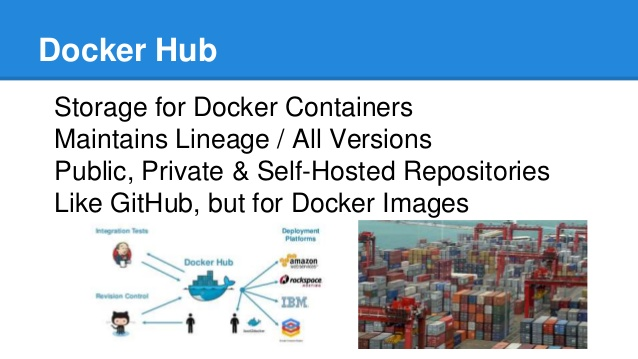

In [59]:
# Ignore this line: it is just to display the image below

curl -s 'http://image.slidesharecdn.com/dockerdemystifiedforsbjug-150918181554-lva1-app6892/95/docker-demystified-for-sb-jug-34-638.jpg' | display

As dockerlabs (dockerlabs AT mjbright.net) with the appropriate password (ask your instructor)

Once logged you should see the dockerlabs/toolset listed, otherwise you can search for it.

Click on the [dockerlabs/toolset](https://hub.docker.com/r/dockerlabs/toolset/) link, then on the [Tags](https://hub.docker.com/r/dockerlabs/toolset/tags/) link and you should now see your tagged image there.

#### Remove any running *'dockerlabs/toolset'* containers on your system

We do this step to make sure we can easily delete your local dockerlabs/toolset:userN image.

These steps could be done by hand through use of 'docker ps' and 'docker ps -a' and picking containers ids corresponding to 'dockerlabs/toolset' containers to use with 'docker stop' and 'docker rm' commands.

The below expressions do this automatically for us.

In [60]:
IMAGE_NAME=dockerlabs/toolset

echo; echo "Currently running or stopped '$IMAGE_NAME' containers"
docker ps -a --filter=ancestor=$IMAGE_NAME

echo; echo "Stopping any running '$IMAGE_NAME' containers (so we can remove dockerlabs/ image)"
docker stop $(docker ps --filter=ancestor=$IMAGE_NAME) 2>/dev/null

echo; echo "Removing any stopped '$IMAGE_NAME' containers (so we can remove dockerlabs/ image)"
docker rm $(docker ps -a --filter=ancestor=$IMAGE_NAME) 2>/dev/null

echo; echo "There should be no more '$IMAGE_NAME' containers present:"
docker ps -a --filter=ancestor=$IMAGE_NAME


Currently running or stopped 'dockerlabs/toolset' containers
CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES

Stopping any running 'dockerlabs/toolset' containers (so we can remove dockerlabs/ image)

Removing any stopped 'dockerlabs/toolset' containers (so we can remove dockerlabs/ image)

There should be no more 'dockerlabs/toolset' containers present:
CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES


In [61]:
docker images dockerlabs/*

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
dockerlabs/toolset   userN               6b82de537bd1        38 minutes ago      3.245 MB


Note that the following rmi command 'Untags' the image.

This is because it is the same - has the same image id - as our original 'lab/toolset' image.

Removing the dockerlabs/toolset image does not remove the identical 'lab/toolset' image but removes the 'dockerlabs/toolset' tag.

In [62]:
docker rmi dockerlabs/toolset:userN

Untagged: dockerlabs/toolset:userN


In [63]:
docker images dockerlabs/*

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE


As we have removed ('untagged') the dockerlabs/toolset image, the following run command will download it from the Docker Hub

In [64]:
docker run dockerlabs/toolset:userN

Unable to find image 'dockerlabs/toolset:userN' locally
userN: Pulling from dockerlabs/toolset




Digest: sha256:b77d291ac6e7b86640922f63048dd55f654cc1b2dc8019647cfbaed20b643cc8
Status: Downloaded newer image for dockerlabs/toolset:userN
Hello world from Go !!


In [65]:
docker images dockerlabs/*

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
dockerlabs/toolset   userN               d34fbee9ad6f        39 minutes ago      3.245 MB


In [66]:
docker run dockerlabs/toolset:userN /helloWorld

Hello World!!


In [67]:
docker run dockerlabs/toolset:userN /hello


Hello from Docker.
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker Hub account:
 https://hub.docker.com

For more examples and ideas, visit:
 https://docs.docker.com/userguide/



<a name="build-best-practices"/>
## Dockerfile best practices
[TOP](#TOP)

<font size=+1 color="#77f">
<b>The goal of this step is to demonstrate certain Dockerfile optimizations.</b>
</font>

- group related commands together using '&&' to reduce image layers
- if temporary files are to be removed


In [68]:
cd ~/src/build-best-practices
cat Dockerfile


FROM ubuntu

MAINTAINER "Docker Labs" <dockerlabs@mjbright.net>

#
# Instead of perofmring the followinf commands individually which
# involves creating a separate image layer for each RUN command:
#   RUN apt-get update
#   RUN apt-get -y -q upgrade
#   RUN rm -rf /var/lib/apt/lists/*

# Here we combine the update, upgrade and cleanup steps into one command
# - This produces less image layers (better for disk space and performance)
# - This keeps image smaller by removing temporary files in the same layer
#     If we performed update/upgrade and then rm as a separate step there would
#     be an intermediate layer including those files, making the overall image larger.
#

RUN apt-get update && apt-get -y -q upgrade && rm -rf /var/lib/apt/lists/*



TO be completed ... !!

<a name="lang-stacks" />
## Using the official 'Language Stack' images
[TOP](#TOP)

<a name="medium-node" />
## Creating a Node.js application from the Node.js 'LanguageStack' Docker image
[TOP](#TOP)

Docker provide a set of *'Language Stacks'* which are medium sized images representing the necessary dependencies for a particular language.

<font size=+1 color="#77f">
<b>The goal of this step is to demonstrate the use of Docker-provided *Language Stacks*.</b>
</font>

On the [Docker Hub](https://hub.docker.com/) we can find language stacks available for a variety of languages/environments, each with different release versions (Python 2.x and Python 3.x for example):
- [Node.js (Javascript)](https://hub.docker.com/_/node/)
- [Python](https://hub.docker.com/_/python/)
- [Ruby](https://hub.docker.com/_/ruby/)

You can browse the complete list of *'Official Images*' on the Docker Hub [here](https://hub.docker.com/explore/)

Now let's look at an example of Node.js.
To run a Node.js application this time we will need



In [69]:
docker pull node

Using default tag: latest
latest: Pulling from library/node







Digest: sha256:1bdda7cdd0a8f9c44ac6f51c77de9f42ed3f62efdf557dba6bcca675084de1bd
Status: Image is up to date for node:latest


In [70]:
docker images node

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
node                latest              baa18fdeb577        12 days ago         643.1 MB


In [71]:
docker history node

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
baa18fdeb577        12 days ago         /bin/sh -c #(nop) CMD ["node"]                  0 B                 
<missing>           12 days ago         /bin/sh -c curl -SLO "https://nodejs.org/dist   36.39 MB            
<missing>           12 days ago         /bin/sh -c #(nop) ENV NODE_VERSION=5.5.0        0 B                 
<missing>           12 days ago         /bin/sh -c #(nop) ENV NPM_CONFIG_LOGLEVEL=inf   0 B                 
<missing>           12 days ago         /bin/sh -c set -ex   && for key in     9554F0   51.75 kB            
<missing>           13 days ago         /bin/sh -c apt-get update && apt-get install    314.7 MB            
<missing>           13 days ago         /bin/sh -c apt-get update && apt-get install    122.6 MB            
<missing>           13 days ago         /bin/sh -c apt-get update && apt-get install    44.3 MB             
<missing>   

In [72]:
cd ~/src/nodeJS/
ls -altr

total 24
drwxrwxr-x  2 vagrant vagrant 4096 Feb  7 21:27 src
-rw-rw-r--  1 vagrant vagrant  116 Feb  7 21:27 README.md
-rw-rw-r--  1 vagrant vagrant  315 Feb  7 21:32 Dockerfile
-rwxrwxr-x  1 vagrant vagrant   78 Feb  7 21:32 build_run.sh
drwxrwxr-x  3 vagrant vagrant 4096 Feb  7 21:32 .
drwxrwxr-x 11 vagrant vagrant 4096 Feb  8 15:02 ..


Once again edit the Dockerfile to have the contents shown below:

In [73]:
cat Dockerfile


FROM node

# make the src folder available in the docker image
ADD src/ /src


WORKDIR /src

# install the dependencies from the package.json file
RUN npm install

# make port 80 available outside of the image
EXPOSE 80

# start node with the index.js file of our hello-world application
CMD ["node", "index.js"]



Now let's build  the image

In [74]:
docker build -t node-hello .


Step 1 : FROM node
 ---> baa18fdeb577
Step 2 : ADD src/ /src
 ---> 185d94954037
Removing intermediate container 9bb58bd74883
Step 3 : WORKDIR /src
 ---> Running in ff9be9297185
 ---> b9d929ce3d90
Removing intermediate container ff9be9297185
Step 4 : RUN npm install
 ---> Running in 40468215f688
npm info it worked if it ends with ok
npm info using npm@3.3.12
npm info using node@v5.5.0
npm info attempt registry request try #1 at 4:18:42 PM
npm http request GET https://registry.npmjs.org/express
npm http 200 https://registry.npmjs.org/express
npm info retry fetch attempt 1 at 4:18:50 PM
npm info attempt registry request try #1 at 4:18:50 PM
npm http fetch GET https://registry.npmjs.org/express/-/express-4.12.0.tgz
npm http fetch 200 https://registry.npmjs.org/express/-/express-4.12.0.tgz
npm info attempt registry request try #1 at 4:18:51 PM
npm http request GET https://registry.npmjs.org/accepts
npm info attempt registry request try #1 at 4:18:51 PM
npm http request GET https://registry

and run the image in the background, exposing port 80

In [75]:
docker run -p 80:80 --name web -d node-hello

c43f44797eddb266ffa9d9d69fa91e12927284f8ec0af209193865ca3a43b434


Now let's use curl to access this container (default port for curl is 80)

In [76]:
curl http://localhost

<html><body>Hello from Node.js container c43f44797edd</body></html>

<a name="medium-python"/>
## Creating a Python application from the Python 'LanguageStack' Docker image
[TOP](#TOP)

<font size=+1 color="#77f">
<b>The goal of this step is to demonstrate the use of the Python *Language Stack*.</b>
</font>

Now let's look at a Python example.
To run a Node.js application this time we will need


Let's pull and examine the official 'Docker Language Stack' image of Python

Note how the earliest image layers (at the bottom of the list) have the same image ids
as the earliest image layers of the Node;js image.

So we can see that they were both created from the same base.

In [77]:
docker pull python

Using default tag: latest
latest: Pulling from library/python








Digest: sha256:4651b83dd903ce78b1c455794f63d4108d9469a6c7fe97cd07d08a77b7e72435
Status: Image is up to date for python:latest


In [78]:
docker images python

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
python              latest              93049cc049a6        12 days ago         689.1 MB


In [79]:
docker history python

IMAGE               CREATED             CREATED BY                                      SIZE                COMMENT
93049cc049a6        12 days ago         /bin/sh -c #(nop) CMD ["python3"]               0 B                 
<missing>           12 days ago         /bin/sh -c cd /usr/local/bin  && ln -s easy_i   48 B                
<missing>           12 days ago         /bin/sh -c set -ex  && gpg --keyserver ha.poo   81.53 MB            
<missing>           12 days ago         /bin/sh -c #(nop) ENV PYTHON_PIP_VERSION=7.1.   0 B                 
<missing>           12 days ago         /bin/sh -c #(nop) ENV PYTHON_VERSION=3.5.1      0 B                 
<missing>           12 days ago         /bin/sh -c #(nop) ENV GPG_KEY=97FC712E4C024BB   0 B                 
<missing>           12 days ago         /bin/sh -c #(nop) ENV LANG=C.UTF-8              0 B                 
<missing>           12 days ago         /bin/sh -c apt-get purge -y python.*            978.7 kB            
<missing>   

The following command will run the 'python' docker image, invoking the command 'python --version' to show us which default python version is available.

In [80]:
docker run python python --version

Python 3.5.1


Now let's look at extending this to a small 2-tier application with Flask web server as front-end and Redis as a backend database (counter) to count access to a web page.

To run this application create a Dockerfile with the following contents in the 'python_flask' directory

In [81]:
cd ~/src/python_flask
cat Dockerfile

FROM python:2.7

MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>

WORKDIR /src

ADD requirements.txt /src/

RUN pip install -r requirements.txt

ADD . /src

CMD python flask_redis_app.py



In [82]:
docker build -t lab/python_flask .



Step 1 : FROM python:2.7
2.7: Pulling from library/python








Digest: sha256:84d75f33b4ae12997a0a2d51481ed18525ee7b49a5660c3301a00dfb2db19a14
Status: Downloaded newer image for python:2.7
 ---> 31093b2dabe2
Step 2 : MAINTAINER "Docker Build Lab" <dockerlabs@mjbright.net>
 ---> Running in 404474a045cb
 ---> 7aa58734ef0a
Removing intermediate container 404474a045cb
Step 3 : WORKDIR /src
 ---> Running in 1709c7d0613f
 ---> 50364340ba7d
Removing intermediate container 1709c7d0613f
Step 4 : ADD requirements.txt /src/
 ---> 2a48226d80a9
Removing intermediate container 86e962852b66
Step 5 : RUN pip install -r requirements.txt
 ---> Running in b6136d317c71
  Running setup.py bdist_wheel for flask
  Stored in directory: /root/.cache/pip/wheels/d2/db/61/cb9b80526b8f3ba89248ec0a29d6da1bb6013681c930fca987
  Running setup.py bdist_wheel for itsdangerous
  Stored in directory: /root/.cache/pip/wheels/97/c0/b8/b37c320ff57e15f993ba0ac98013eee778920b4a7b3ebae3cf
  Running setup.py bdist_wheel for 

In [83]:
docker images lab/*

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
lab/python_flask    latest              64113b113a8a        17 seconds ago      682.9 MB
lab/toolset         latest              6b82de537bd1        44 minutes ago      3.245 MB
lab/go-hello        latest              438d3567ae8a        45 minutes ago      2.367 MB
lab/basic           latest              e3d7946e9d93        48 minutes ago      689.1 MB
lab/c_prog          latest              659400ddd8d4        18 hours ago        877.2 kB


Now let's run this container in the background

First we must launch our redis DB as a background container, it will be used to count the number of page accesses.

For this we launch a container instance of the 'redis' image, as a background process (-d) and we also give the instance the name 'redis' also. This will allow our 'flask' container to link to this image

In [85]:
docker run -d --name redis redis

b00a2d863d93bd50ea13bba2046bd6325097f05195b8d3799239a93bd5694817


Now we launch our 'flask' image which will be our web server.

We also launch that container in the background.  Note that we link to the 'redis' container.  This allows the 'flask' container to connect to the redis database to get and increment the counter value

In [86]:
docker run -d --link redis:db -p 5000:5000 lab/python_flask

f2b3fffe66eff7279d9e4d47cd15bb7e2ae6033552d5c335e6627cc8b017c44c


Now as we make successive curl (or web browser) requests to our 'flask' web server we see that page access counter gets incremented

In [87]:
curl http://localhost:5000


Hello World!
This page has been visited 1 times.
On host f2b3fffe66ef



In [88]:
curl http://localhost:5000


Hello World!
This page has been visited 2 times.
On host f2b3fffe66ef



In [89]:
curl http://localhost:5000


Hello World!
This page has been visited 3 times.
On host f2b3fffe66ef



In [90]:
curl http://localhost:5000


Hello World!
This page has been visited 4 times.
On host f2b3fffe66ef



  <a name="Compose" />
#   Using Compose
<a href="#TOP">TOP</a>
  
#   Building complex systems with Compose
<a href="#TOP">TOP</a>

In [91]:
cd ~/src/compose

Create a docker-compose.yml specification file with the following contents.

This is a 2-tier architecture with 

In [94]:
cat docker-compose.yml


version: 2
services:
  weba:
    build: ../nodeJS
    expose:
      - 80

  webb:
    build: ../nodeJS
    expose:
      - 80

  webc:
    build: ../nodeJS
    expose:
      - 80

  haproxy:
    image: haproxy
    volumes:
     - ./haproxy:/usr/local/etc/haproxy/
    links:
     - weba
     - webb
     - webc
    ports:
     - "80:80"
     - "70:70"
    expose:
     - "80"
     - "70"




Let's look at the docker-compose options

In [95]:
docker-compose

Define and run multi-container applications with Docker.

Usage:
  docker-compose [-f=<arg>...] [options] [COMMAND] [ARGS...]
  docker-compose -h|--help

Options:
  -f, --file FILE           Specify an alternate compose file (default: docker-compose.yml)
  -p, --project-name NAME   Specify an alternate project name (default: directory name)
  --verbose                 Show more output
  -v, --version             Print version and exit

Commands:
  build              Build or rebuild services
  config             Validate and view the compose file
  create             Create services
  down               Stop and remove containers, networks, images, and volumes
  events             Receive real time events from containers
  help               Get help on a command
  kill               Kill containers
  logs               View output from containers
  pause              Pause services
  port               Print the public port for a port binding
  ps                 List containers
  pul

Let's first do some cleanup of any existing containers invoked by compose

In [99]:
docker-compose stop

In [102]:
docker-compose rm -f

No stopped containers


Remove any other containers which might be listening on port 80 - here we stop and remove all containers to be sure

In [101]:
docker stop $(docker ps -q)
docker rm $(docker ps -aq)

f2b3fffe66ef
b00a2d863d93
c43f44797edd
f2b3fffe66ef
b00a2d863d93
c43f44797edd


Now we will startup our system.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;docker-compose up

will startup the containers specified in docker-compose.yml (first building any images where 'build:' is specified)

Launching in the foreground will produce the following output:

```
Creating compose_webc_1
Building weba
Step 1 : FROM node
 ---> baa18fdeb577
Step 2 : ADD src/ /src
 ---> Using cache
 ---> 6d6e1fb506d4
Step 3 : WORKDIR /src
 ---> Using cache
 ---> f293e728d28f
Step 4 : RUN npm install
 ---> Using cache
 ---> 16107856389c
Step 5 : EXPOSE 80
 ---> Using cache
 ---> eed510133b6b
Step 6 : CMD node index.js
 ---> Using cache
 ---> 2e6df94ecab1
Successfully built 2e6df94ecab1
Creating compose_weba_1
Creating compose_haproxy_1
Attaching to compose_webb_1, compose_webc_1, compose_weba_1, compose_haproxy_1
webb_1    | Running on http://localhost
webc_1    | Running on http://localhost
weba_1    | Running on http://localhost
haproxy_1 | [WARNING] 038/165945 (1) : Server aj_backends/weba is UP, reason: Layer7 check passed, code: 200, info: "HTTP status check returned code <3C>200<3E>", check duration: 6ms. 3 active and 0 backup servers online. 0 sessions requeued, 0 total in queue.
```

where we see that the necessary images were built and then started.
We also see startup of the haproxy container and it's checks that it can contact the web servers.

Let's start the containers in the background

In [103]:
docker-compose up -d

Creating compose_webb_1
Creating compose_webc_1
Creating compose_weba_1
Creating compose_haproxy_1


Now we can see that appropriate images have been built and we can also use 'docker-compose ps' to see the running elements of our system

In [104]:
docker images compose*

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE
compose_weba        latest              2e6df94ecab1        4 minutes ago       645.8 MB
compose_webb        latest              2e6df94ecab1        4 minutes ago       645.8 MB
compose_webc        latest              2e6df94ecab1        4 minutes ago       645.8 MB


In [105]:
docker-compose ps

      Name             Command             State              Ports       
-------------------------------------------------------------------------
compose_haproxy_   haproxy -f         Up                 0.0.0.0:70->70/t 
1                  /usr/local/etc/                       cp, 0.0.0.0:80-> 
                   ...                                   80/tcp           
compose_weba_1     node index.js      Up                 80/tcp           
compose_webb_1     node index.js      Up                 80/tcp           
compose_webc_1     node index.js      Up                 80/tcp           


Now we can use curl connecting to localhost:80 (on which the haproxy container is listening) and we will see how haproxy is doing roundrobin scheduling to each of our web containers

In [106]:
curl localhost:80

<html><body>Hello from Node.js container 8727c713bfd4</body></html>

In [107]:
curl localhost:80

<html><body>Hello from Node.js container 594f34c12cb5</body></html>

In [108]:
curl localhost:80

<html><body>Hello from Node.js container 3ebf9e175082</body></html>

Note how the container id changes each time.

Now we can try scaling one of our services as shown below:

In [109]:
docker-compose scale weba=5

With 'docker-compose ps' we see that we now have scaled to 5 'weba' servers:

In [110]:
docker-compose ps

      Name             Command             State              Ports       
-------------------------------------------------------------------------
compose_haproxy_   haproxy -f         Up                 0.0.0.0:70->70/t 
1                  /usr/local/etc/                       cp, 0.0.0.0:80-> 
                   ...                                   80/tcp           
compose_weba_1     node index.js      Up                 80/tcp           
compose_weba_2     node index.js      Up                 80/tcp           
compose_weba_3     node index.js      Up                 80/tcp           
compose_weba_4     node index.js      Up                 80/tcp           
compose_weba_5     node index.js      Up                 80/tcp           
compose_webb_1     node index.js      Up                 80/tcp           
compose_webc_1     node index.js      Up                 80/tcp           


In [111]:
curl localhost:80
curl localhost:80
curl localhost:80
curl localhost:80
curl localhost:80
curl localhost:80

<html><body>Hello from Node.js container 8727c713bfd4</body></html><html><body>Hello from Node.js container 594f34c12cb5</body></html><html><body>Hello from Node.js container 3ebf9e175082</body></html><html><body>Hello from Node.js container 8727c713bfd4</body></html><html><body>Hello from Node.js container 594f34c12cb5</body></html><html><body>Hello from Node.js container 3ebf9e175082</body></html>

Now let's stop our current system

In [113]:
docker-compose stop
docker-compose rm -f
docker-compose ps

No stopped containers
Name   Command   State   Ports 
------------------------------


<a name="building-docker" />
# Building Docker
<a href="#TOP">TOP</a>

<a name="Building-Docker-with-Docker" />
# Building Docker with Docker
<a href="#TOP">TOP</a>

A major advantage of Docker is to simplify build environments.

Let's look at how we can build the Docker engine client/daemon binary without having to explicitly install a development environment.

<font size=+1 color="#77f">
<b>The goal of this step is simply to show the ease with which we can build Docker, thanks to Docker itself.</b>   
</font>

We do not make particular use of the built image.

The process involves the following steps, several of which have already been performed so as to prevent excessive network utilisation during the lab.  Nevertheless all steps are  described here so that you can see just how easy it is to build Docker from scratch:
- Install make
- Clone the Docker source code
- Checkout the same code revision as our current Docker binary (client and daemon)
- Build the code - which pulls the docker-dev image containing the required version of the Go compiler
- Run the executable to demonstrate it is correct

#### Installing make

In your environment we have already installed the make package, but no compiler using yum:

    yum install make

#### Cloning the Docker source code

We have already downloaded the Docker source code from github as follows:

    mkdir -p /root/src/docker
    cd /root/src/docker
    git clone https://github.com/docker/docker .

To build Docker we simply have to build using the

    make build
    
command.

#### Checkout the source code revision corresponding to our installed Docker Engine

If we build the latest sources this may not be compatible with our installed Docker version.

This is the case.  We have 1.10.0-rc2 installed, which has API version 22, but the current github source is 1.10.0-dev which has changed to API version 23.  So if we build this we find that we cannot use this client to communicate with the installed daemon.

So let's checkout the code for 1.10.0-rc2.

At the time of writing this is the latest release(candidate) of the Docker engine.
We can obtain that version of the source code by referring to the releases page https://github.com/docker/docker/releases
and selecting the SHA1 hash of build 1.10.0-rc2 

    git checkout c1cdc6e



#### Build the code - which pulls the docker-dev image containing the required version of the Go compiler

We can build the code as follows:

    make build
    
We have run 'make build' already, so the docker-dev image has already been downloaded (again to prevent excessive network traffic).  The docker-dev image includes the required go compiler and other build tools.

Run 'make build' again and you will see a standard build process and finally where it places the compiled binary

#### Run the executable to demonstrate it is correct

In preparation for the lab we built from the latest source (not the c1cdc6e version we checked out).

Run this build as follows to see that it is not compatible with the installed binary (/usr/bin/docker).
We see that this binary has version 1.10.0-dev and API version 1.23 but that this cannot communicate with our installed binary which has API version 1.22.

In [ ]:
cd /root/src/docker; ls -altr bundles/1.10.0-dev/binary/docker-1.10.0-dev; ./bundles/1.10.0-dev/binary/docker version

But if we run our new build - as follows - created from revision c1cdc6e of the source code (corresponding to Docker version 1.10.0-rc2) we see that it has the correct version, with the same API version and can interrogate the server.


In [ ]:
cd /root/src/docker; ls -altr bundles/1.10.0-rc2/binary/docker-1.10.0-rc2; ./bundles/1.10.0-rc2/binary/docker version

# References
[TOP](#TOP)

- [Dockerfile Reference](https://docs.docker.com/engine/reference/builder/)

- [Compose file documentation](https://docs.docker.com/compose/compose-file/)

- [Compose file reference](https://github.com/docker/compose/blob/1.6.0-rc1/docs/compose-file.md)

- [Visualizing Docker Containers and Images](http://merrigrove.blogspot.in/2015/10/visualizing-docker-containers-and-images.html)

- [Awesome Docker](https://github.com/veggiemonk/awesome-docker)

- [Docker Cheat Sheet]()

- [Building Good Docker Images](http://jonathan.bergknoff.com/journal/building-good-docker-images)

- [How to scale a Docker Container with Docker Compose](https://www.brianchristner.io/how-to-scale-a-docker-container-with-docker-compose/)

- [Docker Compose Demo](https://github.com/vegasbrianc/docker-compose-demo)
